## In this notebook, we will be handling:
- **model building**: building decision tree and random forest models
- **model evaluation**: identifying models with high precision and recall, and improving performance through K-fold Cross Validation

In [123]:
import pandas as pd
from scipy.stats import pointbiserialr
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#### Step 1: Import Feature Matrix 
Convert fully_funded label into binary labels

In [181]:
merged_df = pd.read_csv("merged_data.csv")

In [182]:
merged_df['fully_funded'] = merged_df['fully_funded'].replace({'t': 1, 'f': 0})
X = merged_df.drop(columns=['projectid', 'fully_funded'])
y = merged_df['fully_funded']

#### Step 2: Create Data Sample

Use stratified sampling, split data into training set (20% of data) and testing set (80% of data), and perform final encoding on categorical features and column names, ensuring that the test and training sets have the same column names

Please note: In our initial attempt to train the model with 80% of the dataset, our model took about 40+ minutes to run. As such, we reducd the amount of data used to 20% of the original dataset. While this allows us to continue training different models with run times of less than 10 minutes, it likely impacts our results. In the real world, we would use a machine with stronger computer power than a laptop to train on a larger portion of the dataset, before making any recommendations based on our model.

In [186]:
X_sample, _, y_sample, _ = train_test_split(
    merged_df.drop(columns=['projectid', 'fully_funded']),
    merged_df['fully_funded'],
    test_size=0.80, stratify=merged_df['fully_funded'], random_state=42 
)

In [188]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.8, random_state=42
)
X_train = pd.get_dummies(X_train_raw, drop_first=True)
X_test = pd.get_dummies(X_test_raw, drop_first=True)

In [190]:
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [191]:
def clean_column_names(df):
    df.columns = (
        df.columns.astype(str)
        .str.replace(r"[^a-zA-Z0-9_]", "", regex=True)  
        .str.replace(" ", "_", regex=False)  
    )
    return df

X_train = clean_column_names(X_train)
X_test = clean_column_names(X_test)

#### Step 3: Define models of interest and SMOTE oversampling and undersampling Strategies

In [ ]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)}

In [ ]:
sampling_strategies = {
    'SMOTE (Oversampling)': SMOTE(random_state=42),
    'RUS (Undersampling)': RandomUnderSampler(random_state=42)
}

#### Step 4: Build Baseline Decision Tree and Random Forest Models 

- For underfunded projects (fully_funded=0), we find that the random forest with undersampling of data produced the highest recall, and and the random forest with oversampling produced the highest precision

In [85]:
for sampling_name, sampler in sampling_strategies.items():
    print(f"\n=== Sampling Strategy: {sampling_name} ===")

    X_small, _, y_small, _ = train_test_split(X_train, y_train, test_size=0.8, stratify=y_train, random_state=42)

    X_resampled, y_resampled = sampler.fit_resample(X_small, y_small)

    for model_name, model in models.items():
        print(f"\n--- Model: {model_name} ---")

        model.fit(X_resampled, y_resampled)

        # Predictions
        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_resampled)

        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
        print("\nClassification Report:\n", classification_report(y_test, y_pred_test))
        print(f"Train Accuracy: {accuracy_score(y_resampled, y_pred_train):.4f}")
        print(f"Test Accuracy:  {accuracy_score(y_test, y_pred_test):.4f}")


=== Sampling Strategy: SMOTE (Oversampling) ===

--- Model: Random Forest ---
Confusion Matrix:
 [[1013 2249]
 [ 923 9706]]

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.31      0.39      3262
           1       0.81      0.91      0.86     10629

    accuracy                           0.77     13891
   macro avg       0.67      0.61      0.62     13891
weighted avg       0.74      0.77      0.75     13891

Train Accuracy: 0.9996
Test Accuracy:  0.7717

--- Model: Decision Tree ---
Confusion Matrix:
 [[1297 1965]
 [1832 8797]]

Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.40      0.41      3262
           1       0.82      0.83      0.82     10629

    accuracy                           0.73     13891
   macro avg       0.62      0.61      0.61     13891
weighted avg       0.72      0.73      0.72     13891

Train Accuracy: 0.9996
Test Accuracy:  0.7267

==

In [ ]:
X_raw = merged_df.drop(columns=['projectid', 'fully_funded'])
y = merged_df['fully_funded']
X_encoded = pd.get_dummies(X_raw, drop_first=True)
X_encoded = clean_column_names(X_encoded)


#### Step 5: K-Fold Cross Validation
Given the baseline decision tree and random forest models built using SMOTE oversampling and undersampling, we now seek to increase our precision and recall scores by using K-fold cross validation.
- We find that cross validation increases recall and precision increase across all models, with the random forest SMOTE oversampling resulting in the highest scores.

In [89]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  

results = {}

for sampling_name, sampler in sampling_strategies.items():
    print(f"\n=== Sampling Strategy: {sampling_name} ===")
    results[sampling_name] = {}

    X_resampled, y_resampled = sampler.fit_resample(X_encoded, y)

    for model_name, model in models.items():
        print(f"\n--- Model: {model_name} ---")

        pipeline = Pipeline([('model', model)])  

        y_pred = cross_val_predict(pipeline, X_resampled, y_resampled, cv=cv, n_jobs=-1)

        acc = accuracy_score(y_resampled, y_pred)
        cm = confusion_matrix(y_resampled, y_pred)
        cr = classification_report(y_resampled, y_pred)

        print("Confusion Matrix:\n", cm)
        print("\nClassification Report:\n", cr)
        print(f"CV Accuracy: {acc:.4f}")

        results[sampling_name][model_name] = {
            'accuracy': acc,
            'confusion_matrix': cm,
            'classification_report': classification_report(y_resampled, y_pred, output_dict=True)
        }
(f"Test Accuracy:  {accuracy_score(y_test, y_pred_test):.4f}")



=== Sampling Strategy: SMOTE (Oversampling) ===

--- Model: Random Forest ---
Confusion Matrix:
 [[44559  8582]
 [ 5317 47824]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.84      0.87     53141
           1       0.85      0.90      0.87     53141

    accuracy                           0.87    106282
   macro avg       0.87      0.87      0.87    106282
weighted avg       0.87      0.87      0.87    106282

CV Accuracy: 0.8692

--- Model: Decision Tree ---
Confusion Matrix:
 [[43511  9630]
 [ 9148 43993]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.82     53141
           1       0.82      0.83      0.82     53141

    accuracy                           0.82    106282
   macro avg       0.82      0.82      0.82    106282
weighted avg       0.82      0.82      0.82    106282

CV Accuracy: 0.8233

=== Sampling Strategy: RUS (Undersampling) ===

'Test Accuracy:  0.6432'

#### Step 6: Define the Best Model
We have identified the random forest model above which used SMOTE oversampling and k-fold cross validation as the model which produced the highest precision and recall scores. As such, we attempt to define the model below. Unfortunately, we were having issues with this definition taking over 30 minutes to run, and added new constraints to speed up the run time, including training on only 1% of the data, resampling with SMOTE on only 50% of the minority class to generate fewer additional datapoints, and restricting the number of trees to 10. We find that this reduces the precision and recall scores that we had previously found, but will proceed with this model for the sake of model-run time in the project.

A future iteration of this project should utilize a more powerful computer than a laptop to build the original random forest model with SMOTE oversampling and 3 k-fold splits.


In [10]:
merged_df['fully_funded'] = merged_df['fully_funded'].replace({'t': 1, 'f': 0}).astype(int)
X_raw = merged_df.drop(columns=['projectid', 'fully_funded'])
y = merged_df['fully_funded']

X_encoded = pd.get_dummies(X_raw, drop_first=True).iloc[:, :50]

X_small, _, y_small, _ = train_test_split(X_encoded, y, test_size=0.99, stratify=y, random_state=42)

X_resampled, y_resampled = SMOTE(sampling_strategy=0.5, random_state=42).fit_resample(X_small, y_small)

best_model = RandomForestClassifier(n_estimators=10, max_depth=3, n_jobs=-1, random_state=42)

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
pipeline = Pipeline([("model", best_model)])
y_pred = cross_val_predict(pipeline, X_resampled, y_resampled, cv=cv, n_jobs=-1)

accuracy = accuracy_score(y_resampled, y_pred)
print(f"\nMinimal Random Forest Model Accuracy: {accuracy:.4f}")

report = classification_report(y_resampled, y_pred)
print("\nClassification Report:")
print(report)



Minimal Random Forest Model Accuracy: 0.6709

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.15      0.23       265
           1       0.69      0.93      0.79       531

    accuracy                           0.67       796
   macro avg       0.60      0.54      0.51       796
weighted avg       0.63      0.67      0.61       796



#### Step 7: Identify Features Most Predictive of Project Underfunding
Using the best_model defined above, we identify the probability of being underfunded (fully_funded=0) for each project, and assess features of those above the 90th percential, which are the top 10% least likely to be funded projects. We then assign an importance score to each feature, and measure correlations between the top 5 features and their underfunding probability. We find the following:

- Projects with a higher number of students reached are somewhat positively correlated with underfunding, indicating that projects serving more students are less likely to be funded than projects which serve fewer students
- school zip is somewhat positively correlated with underfunding, indicating that projects in certain zipcodes are less likely to be underfunded than others
- price caps including and excluding optional support have the most positive correlation with underfunding out of all features, indicating that higher cost projects are more likely to be underfunded than lower cost projects
- eligible matching funds are somewhat negatively correlated with underfunding, indicating that matching donations somewhat reduce a project's likelihood of being underfunded


Top Features Predicting Underfunded Projects:
                                       Feature  Importance
9                     students_reached_capped    0.210557
0                                  school_zip    0.180750
8                             price_capped_in    0.155378
6                  eligible_almost_home_match    0.140579
7                             price_capped_ex    0.114717
4                 fulfillment_labor_materials    0.083796
2                               school_magnet    0.045913
5           eligible_double_your_impact_match    0.035216
18  schoolid_00f2a378ce7159db159809eb15fa3f03    0.033094
31  schoolid_01f6b44bd0c7d514b183a1ee94cd32c0    0.000000


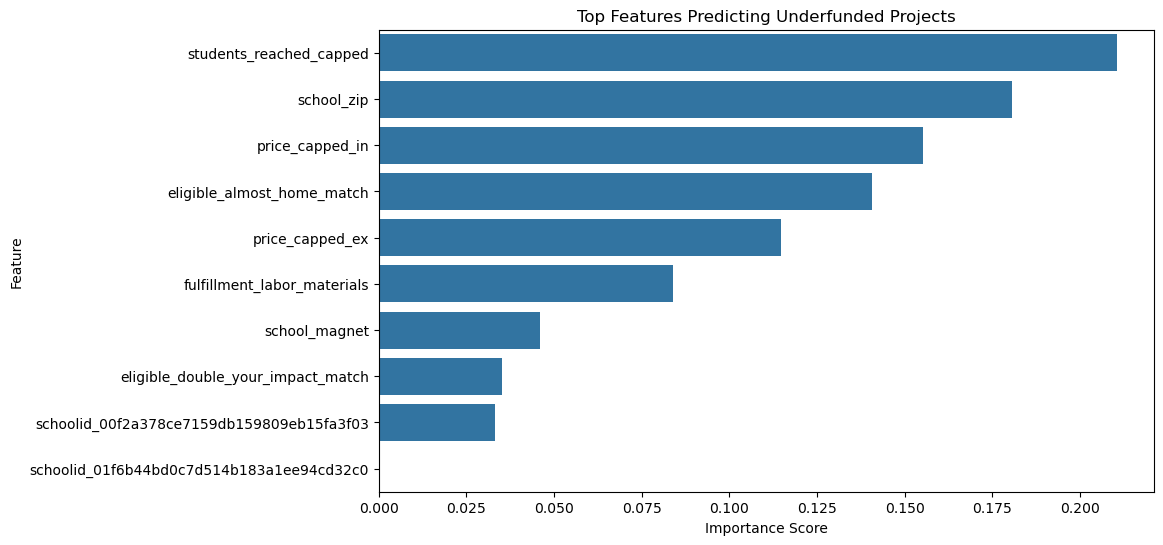

In [166]:
expected_features = best_model.feature_names_in_
X_resampled = X_resampled[expected_features]  

y_pred_prob = best_model.predict_proba(X_resampled)[:, 0]  # Class 0 = underfunded

threshold = np.percentile(y_pred_prob, 90)

least_funded_mask = y_pred_prob >= threshold
least_funded_projects = X_resampled[least_funded_mask]
least_funded_labels = y_resampled[least_funded_mask]

rf_underfunded = RandomForestClassifier(n_estimators=10, max_depth=3, n_jobs=-1, random_state=42)
rf_underfunded.fit(least_funded_projects, least_funded_labels)

underfunded_importance_df = pd.DataFrame({
    "Feature": least_funded_projects.columns,
    "Importance": rf_underfunded.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nTop Features Predicting Underfunded Projects:\n", underfunded_importance_df.head(10))

selected_features = ["students_reached_capped", "school_zip", "price_capped_in", 
                     "eligible_almost_home_match", "price_capped_ex"]
correlations = {}
for feature in selected_features:
    corr, _ = pointbiserialr(y_resampled, X_resampled[feature])
    correlations[feature] = corr

corr_df = pd.DataFrame(correlations, index=["Underfunding"]).T

# Feature importance bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=underfunded_importance_df.head(10), x="Importance", y="Feature")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top Features Predicting Underfunded Projects")
plt.show()


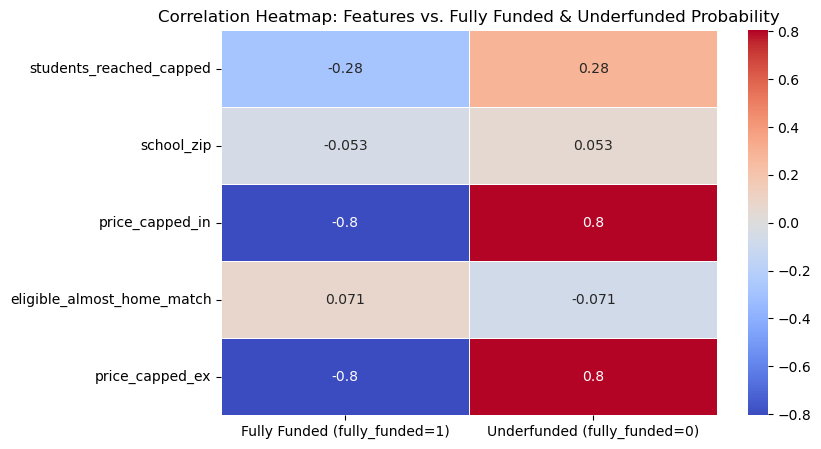

In [167]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr

y_pred_prob_funded = best_model.predict_proba(X_resampled)[:, 1]  
y_pred_prob_underfunded = best_model.predict_proba(X_resampled)[:, 0]  

selected_features = ["students_reached_capped", "school_zip", "price_capped_in", 
                     "eligible_almost_home_match", "price_capped_ex"]

correlations = {}
for feature in selected_features:
    corr_funded, _ = pointbiserialr(y_pred_prob_funded, X_resampled[feature])
    corr_underfunded, _ = pointbiserialr(y_pred_prob_underfunded, X_resampled[feature])
    correlations[feature] = {"Fully Funded (fully_funded=1)": corr_funded, "Underfunded (fully_funded=0)": corr_underfunded}

corr_df = pd.DataFrame.from_dict(correlations, orient="index")

plt.figure(figsize=(8, 5))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Heatmap: Features vs. Fully Funded & Underfunded Probability")
plt.show()



#### Step 8: Exploring Features

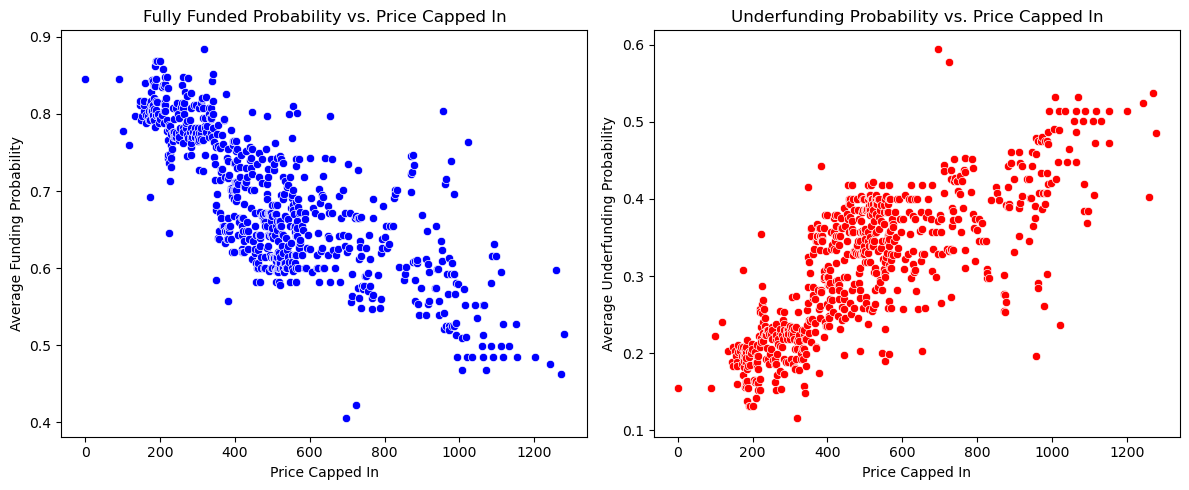

In [155]:
y_pred_prob_funded = best_model.predict_proba(X_resampled)[:, 1]  

y_pred_prob_underfunded = best_model.predict_proba(X_resampled)[:, 0] 

funding_prob_by_price = pd.DataFrame({
    "price_capped_in": X_resampled["price_capped_in"],
    "funding_prob": y_pred_prob_funded,
    "underfunded_prob": y_pred_prob_underfunded
}).groupby("price_capped_in").mean()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x=funding_prob_by_price.index, y=funding_prob_by_price["funding_prob"], color="blue", ax=axes[0])
axes[0].set_xlabel("Price Capped In")
axes[0].set_ylabel("Average Funding Probability")
axes[0].set_title("Fully Funded Probability vs. Price Capped In")

sns.scatterplot(x=funding_prob_by_price.index, y=funding_prob_by_price["underfunded_prob"], color="red", ax=axes[1])
axes[1].set_xlabel("Price Capped In")
axes[1].set_ylabel("Average Underfunding Probability")
axes[1].set_title("Underfunding Probability vs. Price Capped In")

plt.tight_layout()
plt.show()

